# plotting correlation between heterogeneous reconstruction and MD trajectory
This notebook computes the correlation between frames of the MD trajectory and volumes reconstructed by cryoDRGN / cryoSPARC

In [24]:
# imports
import os
import numpy as np
import gemmi
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed
import warnings
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns

from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter

In [25]:
# functions
def filter_gemmi_model(model_gemmi, remove_sidechains=False):
    # remove ligand residues and all sidechain atoms
    list_of_residue_names = [
        "ZN", "A", "C", "G", "U", "ADP", "ATP", "ACE", "MG",
    ]
    new_model_gemmi = gemmi.Model(model_gemmi.name)
    for chn in model_gemmi:
        new_chain_gemmi = gemmi.Chain(chn.name)
        for res in chn:
            if res.name not in list_of_residue_names:
                new_res_gemmi = gemmi.Residue()
                new_res_gemmi.name = res.name
                new_res_gemmi.seqid.num = res.seqid.num
                
                if remove_sidechains:
                    for atm in res:
                        if atm.name == "CA":
                            new_atm_gemmi = gemmi.Atom()
                            new_atm_gemmi.name = atm.name
                            new_atm_gemmi.pos = atm.pos
                            new_atm_gemmi.element = gemmi.Element(atm.element.name)
                            new_res_gemmi.add_atom(new_atm_gemmi)

                else:
                    for atm in res:
                        new_atm_gemmi = gemmi.Atom()
                        new_atm_gemmi.name = atm.name
                        new_atm_gemmi.pos = atm.pos
                        new_atm_gemmi.element = gemmi.Element(atm.element.name)
                        new_res_gemmi.add_atom(new_atm_gemmi)                  

                new_chain_gemmi.add_residue(new_res_gemmi)
        new_model_gemmi.add_chain(new_chain_gemmi)
    return new_model_gemmi

# functions
def compute_correlation(modelmap, targetmap, mask, i, j):
    """Compute the correlation between two maps"""
    
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
    # apply mask to both maps
    modelmap_masked = modelmap * mask
    targetmap_masked = targetmap * mask
    # compute the mean of the two maps
    mean_modelmap = np.mean(modelmap_masked)
    mean_targetmap = np.mean(targetmap_masked)
    # compute the standard deviation of the two maps
    std_modelmap = np.std(modelmap_masked)
    std_targetmap = np.std(targetmap_masked)
    # compute the correlation
    correlation = np.mean((modelmap_masked - mean_modelmap) * (targetmap_masked - mean_targetmap)) / (std_modelmap * std_targetmap)
    return correlation, i, j


In [8]:
# create an ensemble structure
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_RTC/20240124_DESRES-Trajectory_sarscov2-13795965-no-water-movies"
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_RTC/mnt/ceph/JGreer/ConformationSampling/DESRES-Trajectory_sarscov2-13795965-no-water/even_sampling/even_sampling_10000"
output_dir = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith(".pdb")]
pdb_files.sort()
N = 50
# sample N files from the total number of files, evenly spaced
pdb_files = pdb_files[::len(pdb_files)//N]

ensemble_gemmi = gemmi.Structure()
ensemble_CA_gemmi = gemmi.Structure()
for filename in pdb_files:
    pdb_path = os.path.join(pdb_dir, filename)
    frame_gemmi = gemmi.read_structure(pdb_path)
    frame_gemmi_filtered = filter_gemmi_model(frame_gemmi[0], remove_sidechains=False)
    ensemble_gemmi.add_model(frame_gemmi_filtered)
    frame_gemmi_CA = filter_gemmi_model(frame_gemmi[0], remove_sidechains=True)
    ensemble_CA_gemmi.add_model(frame_gemmi_CA)

# write the ensemble to a pdb file
ensemble_gemmi.write_pdb(os.path.join(output_dir, "ensemble.pdb"))
ensemble_CA_gemmi.write_pdb(os.path.join(output_dir, "ensemble_CA.pdb"))

In [9]:
unique_res = []
for chn in ensemble_gemmi[0]:
    for res in chn:
        unique_res.append(res.name)
unique_res = np.unique(unique_res)
for res in unique_res:
    print(res)

ALA
ARG
ASN
ASP
CYM
CYS
GLN
GLU
GLY
HIS
ILE
LEU
LYS
MET
NME
PHE
PRO
SER
THR
TRP
TYR
VAL


In [27]:
# save a specific frame without the ligand residues
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_RTC/mnt/ceph/JGreer/ConformationSampling/DESRES-Trajectory_sarscov2-13795965-no-water/even_sampling/even_sampling_10000"
print(project_dir)
output_dir = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble")

conformation = 1000

conformation_filename = f"conformation_{conformation:06d}.pdb"
conformation_path = os.path.join(pdb_dir, conformation_filename)
conformation_gemmi = gemmi.read_structure(conformation_path)
conformation_gemmi_filtered = filter_gemmi_model(conformation_gemmi[0], remove_sidechains=False)
conformation_struct_gemmi = gemmi.Structure()
conformation_struct_gemmi.add_model(conformation_gemmi_filtered)
conformation_struct_gemmi.write_pdb(os.path.join(output_dir, conformation_filename))


/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_RTC/20240124_DESRES-Trajectory_sarscov2-13795965-no-water-movies


## computing correlation matrix

In [13]:
# inputs and parameters
n_frames = 50
resolution = 3
n_jobs = 12

vseries_dir = os.path.join(project_dir, "cryoDRGN", "analyze_320")
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_RTC/mnt/ceph/JGreer/ConformationSampling/DESRES-Trajectory_sarscov2-13795965-no-water/even_sampling/even_sampling_10000"
ensemble_filename = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble", "ensemble_aligned.pdb")
mask_filename = os.path.join(project_dir, "cryoDRGN", "analyze_320", "aligned_ensemble", "ensemble_map.mrc")
figures_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_RTC/DESRES-Trajectory_sarscov2-13795965-no-water-movies/figures"
latent_coordinates = np.arange(0, 50)
inverted_maps = False

frames = [r for r in os.listdir(pdb_dir) if r.endswith(".pdb")]
frames.sort()
frames = frames[::int(len(frames)/n_frames)]

if inverted_maps:
    volumes = [r for r in os.listdir(vseries_dir) if r.endswith("inverted.mrc") and "mask" not in r]
else:
    volumes = [r for r in os.listdir(vseries_dir) if r.endswith(".mrc") and not r.endswith("inverted.mrc") and "mask" not in r]
volumes.sort()

In [11]:
# step 1: load each frame and compute the modelmap
vseries_vol0 = gemmi.read_ccp4_map(os.path.join(vseries_dir, volumes[0]))
unitcell = vseries_vol0.grid.unit_cell
size = vseries_vol0.grid.shape
vsize = vseries_vol0.grid.spacing[0]

# create list of frames
frames_fit = []
ensemble_fit_gemmi = gemmi.read_structure(ensemble_filename)
for mdl in ensemble_fit_gemmi:
    tmp_struc = gemmi.Structure()
    tmp_struc.add_model(mdl)
    frames_fit.append(tmp_struc)

modelmaps = []
for frame_gemmi in tqdm(frames_fit):
    map_from_model_unfiltered = convert_pdb_to_map(
        input_pdb=frame_gemmi,
        unitcell=unitcell,
        size=size,
        return_grid=False,
    )
    map_from_model_zyx = low_pass_filter(
        map_from_model_unfiltered, resolution, vsize
    )
    map_from_model = np.rot90(
        np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
    )
    modelmaps.append(map_from_model)


100%|██████████| 50/50 [21:39<00:00, 25.99s/it]


In [15]:
# step 2: correlate each modelmap with the vseries'

# load vseries
vseries_stack = []
for volume in volumes:
    vseries_vol = gemmi.read_ccp4_map(os.path.join(vseries_dir, volume))
    vseries_stack.append(np.array(vseries_vol.grid))

indecies = itertools.product(range(n_frames), range(len(volumes)))
mask = gemmi.read_ccp4_map(mask_filename)
mask_data = np.array(mask.grid, copy=False)
# threshold = mask_data[mask_data > 0].mean() - 2 * mask_data[mask_data > 0].std()
threshold = 0.1
mask_data[mask_data < threshold] = 0
mask_data[mask_data >= threshold] = 1
# mask_data = np.rot90(np.flip(mask_data, axis=0), axes=(2, 0))

correlations = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_correlation)(modelmaps[i], vseries_stack[j], mask_data, i, j)
    for i, j in indecies
)
correlation_matrix = np.zeros((n_frames, len(volumes)))
for correlation, i, j in correlations:
    correlation_matrix[i, j] = correlation

print(f"correlation average: {np.mean(correlation_matrix)}")
print(f"correlation std: {np.std(correlation_matrix)}")
print(f"correlation min: {np.min(correlation_matrix)}")
print(f"correlation max: {np.max(correlation_matrix)}")


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    9.4s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   12.8s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:   14.9s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   17.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:   18.7s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:   20.7s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:   22.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   24.6s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:   26.8s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:   28.9s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:   31.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   33.7s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

correlation average: 0.6015237797739142
correlation std: 0.07300115615303975
correlation min: 0.41483429870060023
correlation max: 0.7188379431001728


In [19]:
# save the correlation matrix
np.save(os.path.join(project_dir, "cryoDRGN", "analyze_320", "correlation_matrix.npy"), correlation_matrix)

threshold: 0.1


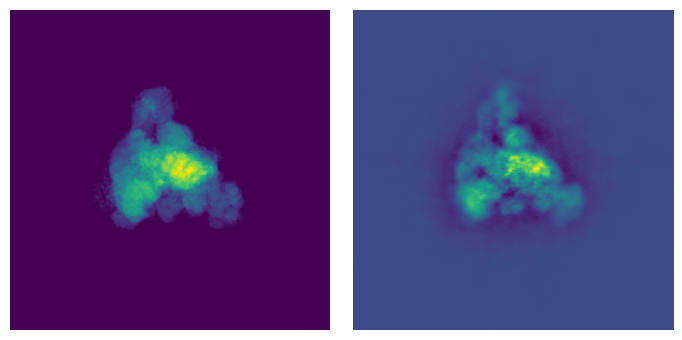

In [17]:
# create projections of the mask
print(f"threshold: {threshold}")
fig, ax = plt.subplots(1,2, figsize=(7, 3.5))
ax[0].imshow(mask_data.sum(axis=0))
ax[1].imshow(vseries_stack[0].sum(axis=0))
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()


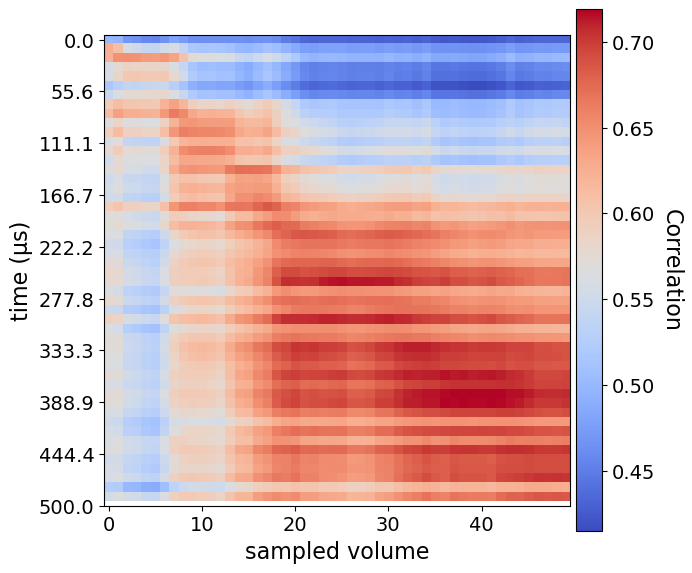

In [16]:
# step 3: plot the correlation matrix
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(correlation_matrix, cmap="coolwarm")
# change the xtick labels for latents
# ax.set_xticks(np.arange(len(volumes)))
# ax.set_xticklabels(
#     [np.round(r, 2) for r in latent_coordinates], rotation=90, fontsize=8)
# set the y-ticklabels to the frames in the pdb_dir
conformation_names = [float(r.split("_")[1].strip(".pdb")) for r in frames]
yticks = np.linspace(0, len(frames), 10)
yticklabels = np.round(np.linspace(0, 500, 10, dtype=float), 1)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel("time (\u03BCs)", fontsize=16)
ax.set_xlabel("sampled volume", fontsize=16)
# ax.set_yticklabels(np.round(np.linspace(0, 10, len(frames)), 2))
# ax.set_yticklabels(conformation_names)
# ax.set_yticklabels([np.round(r*1.2/1000, 1) for r in conformation_names])
# make a colorbar with the same size as the image
cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical", pad=0.01, shrink=0.8)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Correlation", fontsize=16, rotation=270, labelpad=20)
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

# fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.png"), dpi=300, bbox_inches="tight")
# fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.pdf"), bbox_inches="tight")


In [23]:
# for each volume, print the frame with the highest and lowest correlation
results = {
    "volume": [],
    "best_frame": [],
    "best_correlation": [],
    "worst_frame": [],
    "worst_correlation": [],
}
for i, volume in enumerate(volumes):
    max_correlation = np.max(correlation_matrix[:, i])
    max_correlation_index = np.argmax(correlation_matrix[:, i])
    min_correlation = np.min(correlation_matrix[:, i])
    min_correlation_index = np.argmin(correlation_matrix[:, i])
    results["volume"].append(volume)
    results["best_frame"].append(frames[max_correlation_index])
    results["best_correlation"].append(max_correlation)
    results["worst_frame"].append(frames[min_correlation_index])
    results["worst_correlation"].append(min_correlation)

results_df = pd.DataFrame(results)
results_df.head(n=len(volumes))

,volume,best_frame,best_correlation,worst_frame,worst_correlation
0,vol_000.mrc,conformation_000200.pdb,0.627356,conformation_000000.pdb,0.500968
1,vol_001.mrc,conformation_000400.pdb,0.648770,conformation_000000.pdb,0.497100
2,vol_002.mrc,conformation_000400.pdb,0.648869,conformation_000000.pdb,0.470880
3,vol_003.mrc,conformation_000400.pdb,0.646540,conformation_000000.pdb,0.466356
4,vol_004.mrc,conformation_000400.pdb,0.641638,conformation_000000.pdb,0.458567
5,vol_005.mrc,conformation_000400.pdb,0.639067,conformation_000000.pdb,0.455865
6,vol_006.mrc,conformation_000400.pdb,0.645420,conformation_000000.pdb,0.467018
7,vol_007.mrc,conformation_001600.pdb,0.663088,conformation_000000.pdb,0.480602
8,vol_008.mrc,conformation_002000.pdb,0.660753,conformation_000000.pdb,0.473428
9,vol_009.mrc,conformation_003600.pdb,0.659719,conformation_000000.pdb,0.464484


# misc: plot loss function

<>:9: DeprecationWarning: invalid escape sequence '\d'
<>:9: DeprecationWarning: invalid escape sequence '\d'
/tmp/ipykernel_30441/4129352480.py:9: DeprecationWarning: invalid escape sequence '\d'
  pattern = "Epoch: (\d+) Average gen loss = ([0-9.]+), KLD = ([0-9.]+), total loss = ([0-9.]+)"


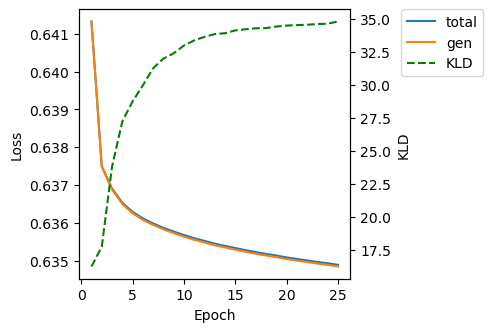

In [22]:
# plot the loss as a function of epoch
logfile = os.path.join(project_dir, "cryoDRGN", "train_320", "run.log")
losses = {
    "epoch": [],
    "gen": [],
    "KLD": [],
    "total": [],
}
pattern = "Epoch: (\d+) Average gen loss = ([0-9.]+), KLD = ([0-9.]+), total loss = ([0-9.]+)"
with open(logfile, "r") as f:
    lines = f.readlines()
    for line in lines:
        match = re.search(pattern, line)
        if match:
            losses["epoch"].append(int(match.group(1)))
            losses["gen"].append(float(match.group(2)))
            losses["KLD"].append(float(match.group(3)))
            losses["total"].append(float(match.group(4)))

df = pd.DataFrame(losses)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(data=df, x="epoch", y="total", ax=ax, label="total", legend=False)
sns.lineplot(data=df, x="epoch", y="gen", ax=ax, label="gen", legend=False)
# plot the KLD on a secondary y-axis
ax2 = ax.twinx()
sns.lineplot(data=df, x="epoch", y="KLD", ax=ax2, color="green", linestyle="--", label="KLD", legend=False)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax2.set_ylabel("KLD")
fig.legend(loc="upper right", bbox_to_anchor=(1.3, 0.9))
